In [ ]:
!mkdir -p ./kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d jtiptj/chest-xray-pneumoniacovid19tuberculosis

Dataset URL: https://www.kaggle.com/datasets/jtiptj/chest-xray-pneumoniacovid19tuberculosis
License(s): other
 99% 1.72G/1.74G [00:10<00:00, 220MB/s]
100% 1.74G/1.74G [00:10<00:00, 184MB/s]


In [ ]:
!unzip /content/chest-xray-pneumoniacovid19tuberculosis.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/train/NORMAL/NORMAL2-IM-0843-0001.jpeg  
  inflating: /content/train/NORMAL/NORMAL2-IM-0845-0001.jpeg  
  inflating: /content/train/NORMAL/NORMAL2-IM-0846-0001.jpeg  
  inflating: /content/train/NORMAL/NORMAL2-IM-0847-0001.jpeg  
  inflating: /content/train/NORMAL/NORMAL2-IM-0848-0001.jpeg  
  inflating: /content/train/NORMAL/NORMAL2-IM-0849-0001.jpeg  
  inflating: /content/train/NORMAL/NORMAL2-IM-0851-0001-0001.jpeg  
  inflating: /content/train/NORMAL/NORMAL2-IM-0851-0001-0002.jpeg  
  inflating: /content/train/NORMAL/NORMAL2-IM-0851-0001.jpeg  
  inflating: /content/train/NORMAL/NORMAL2-IM-0852-0001.jpeg  
  inflating: /content/train/NORMAL/NORMAL2-IM-0853-0001.jpeg  
  inflating: /content/train/NORMAL/NORMAL2-IM-0854-0001.jpeg  
  inflating: /content/train/NORMAL/NORMAL2-IM-0855-0001.jpeg  
  inflating: /content/train/NORMAL/NORMAL2-IM-0856-0001.jpeg  
  inflating: /content/train/NORMAL/NORMAL2-IM-0857-0001.j

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Rescaling
import matplotlib.pyplot as plt
import numpy as np
import random
import os

seed = 123
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
# Directories containing the dataset
train_dir = '/content/train/'  #training data directory
val_dir = '/content/val/'  #validation data directory
test_dir = '/content/test/'  #testing data directory

# Hyperparameters
img_width, img_height = 224, 224
batch_size = 32
epochs = 20
num_classes = 4  # Number of classes (Pneumonia, COVID-19, Tuberculosis, Normal)

In [ ]:
# Load the datasets without validation split
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(img_width, img_height),
    batch_size=batch_size
)

Found 6326 files belonging to 4 classes.


In [ ]:
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=(img_width, img_height),
    batch_size=batch_size
)

Found 38 files belonging to 4 classes.


In [ ]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(img_width, img_height),
    batch_size=batch_size
)

Found 771 files belonging to 4 classes.


In [ ]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [ ]:
# Apply data augmentation only to the training data
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

In [ ]:
# Prefetch the datasets for better performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Steps to follow

Get the dataset.
Data Analysis

- Normalise the dataset
- Use validation split
- Initialise the generators with proper values.
- Data Augmentation
- Autotune and prefetch.
- Model Building.
- Model summary
- Model compile
- Model training
- Model evaluation on train, test, validation
- Performance plots and metrics.
- Model save

In [ ]:
def build_vgg16(input_shape=(224, 224, 3), num_classes=4):
    model = models.Sequential()

    # Add Input Layer
    model.add(layers.Input(shape=input_shape))

    # Normalization Layer
    model.add(Rescaling(1./255))

    # Block 1
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 2
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 3
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 4
    model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 5
    model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

    # Fully connected layers
    model.add(layers.Flatten())

    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))  # Adjust based on number of classes

    return model

In [ ]:
model = build_vgg16(num_classes=num_classes)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                      

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use 'categorical_crossentropy' if labels are one-hot encoded
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs
)

Epoch 1/20
198/198 [==============================] - 958s 5s/step - loss: 1.8010 - accuracy: 0.5979 - val_loss: 1.8418 - val_accuracy: 0.2105
Epoch 2/20
198/198 [==============================] - 934s 5s/step - loss: 1.0593 - accuracy: 0.6126 - val_loss: 1.8330 - val_accuracy: 0.2105
Epoch 3/20
198/198 [==============================] - 934s 5s/step - loss: 1.0591 - accuracy: 0.6126 - val_loss: 1.8051 - val_accuracy: 0.2105
Epoch 4/20
198/198 [==============================] - 934s 5s/step - loss: 1.0610 - accuracy: 0.6126 - val_loss: 1.8737 - val_accuracy: 0.2105
Epoch 5/20
 61/198 [========>.....................] - ETA: 10:45 - loss: 1.0602 - accuracy: 0.6117

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

In [ ]:
# Train set predictions
y_train_true = np.concatenate([y for x, y in train_dataset], axis=0)
y_train_pred = model.predict(train_dataset)
y_train_pred = np.argmax(y_train_pred, axis=1)

# Validation set predictions
y_val_true = np.concatenate([y for x, y in validation_dataset], axis=0)
y_val_pred = model.predict(validation_dataset)
y_val_pred = np.argmax(y_val_pred, axis=1)

# Test set predictions
y_test_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_test_pred = model.predict(test_dataset)
y_test_pred = np.argmax(y_test_pred, axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix

# Confusion matrices
cm_train = confusion_matrix(y_train_true, y_train_pred)
cm_val = confusion_matrix(y_val_true, y_val_pred)
cm_test = confusion_matrix(y_test_true, y_test_pred)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Train Confusion Matrix
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Train Confusion Matrix')
axes[0].set_xlabel('Predicted Labels')
axes[0].set_ylabel('True Labels')

# Validation Confusion Matrix
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Validation Confusion Matrix')
axes[1].set_xlabel('Predicted Labels')
axes[1].set_ylabel('True Labels')

# Test Confusion Matrix
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[2])
axes[2].set_title('Test Confusion Matrix')
axes[2].set_xlabel('Predicted Labels')
axes[2].set_ylabel('True Labels')

# Adjust layout
plt.tight_layout()
plt.show()


# Very Bad Results

# Using Transfer Leanring

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Input

In [ ]:
base_model = VGG16(weights=None,
                   include_top=False,
                   input_tensor=Input(shape=(224, 224, 3)))

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# Load VGG16 with pre-trained ImageNet weights, excluding the top (fully connected) layers
base_model = VGG16(weights='imagenet',
                   include_top=False,
                   input_tensor=Input(shape=(224, 224, 3)))
base_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Build the model
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',  # or 'categorical_crossentropy' if labels are one-hot encoded
              metrics=['accuracy'])

Transfer learning with fixed weight in convultions and training model on FC layers.

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10,
)

Epoch 1/10
198/198 [==============================] - 127s 634ms/step - loss: 1.4729 - accuracy: 0.9148 - val_loss: 0.7282 - val_accuracy: 0.8684
Epoch 2/10
198/198 [==============================] - 126s 633ms/step - loss: 0.2855 - accuracy: 0.9666 - val_loss: 0.4531 - val_accuracy: 0.8947
Epoch 3/10
198/198 [==============================] - 123s 621ms/step - loss: 0.1136 - accuracy: 0.9823 - val_loss: 0.3934 - val_accuracy: 0.9474
Epoch 4/10
198/198 [==============================] - 124s 624ms/step - loss: 0.0667 - accuracy: 0.9858 - val_loss: 0.1267 - val_accuracy: 0.9474
Epoch 5/10
198/198 [==============================] - 123s 620ms/step - loss: 0.0736 - accuracy: 0.9855 - val_loss: 0.3526 - val_accuracy: 0.9211
Epoch 6/10
198/198 [==============================] - 125s 629ms/step - loss: 0.0574 - accuracy: 0.9885 - val_loss: 1.3276 - val_accuracy: 0.8158
Epoch 7/10
198/198 [==============================] - 122s 616ms/step - loss: 0.0637 - accuracy: 0.9885 - val_loss: 0.3311 -

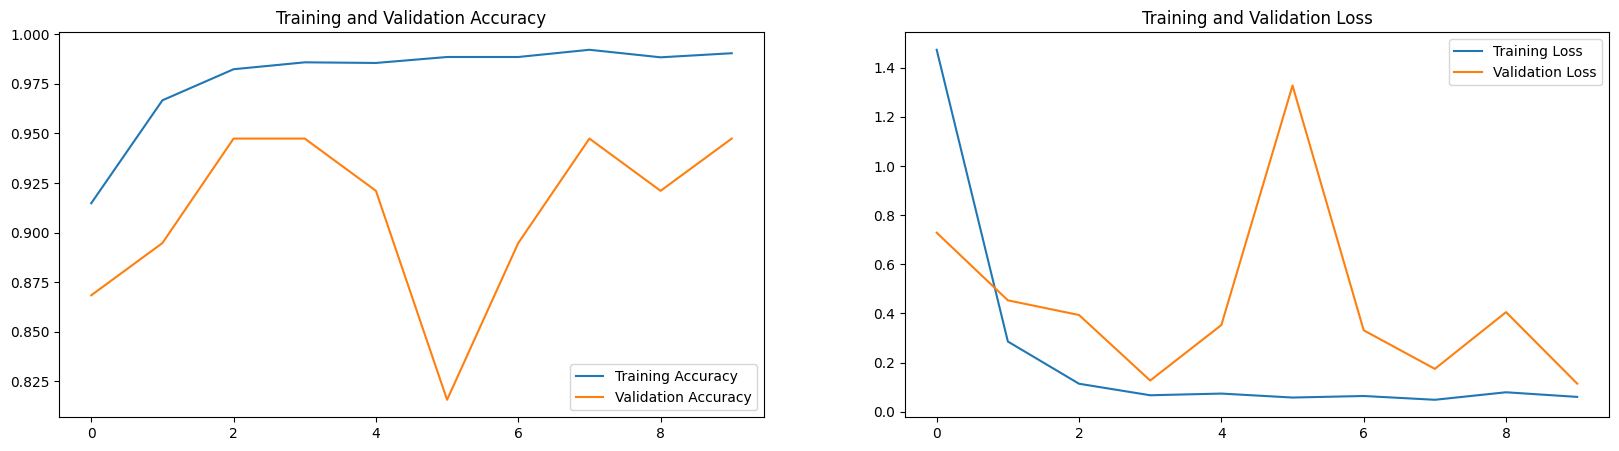

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

25/25 [==============================] - 14s 556ms/step - loss: 3.2591 - accuracy: 0.8197
Test Accuracy: 81.97%


In [ ]:
# Train set predictions
y_train_true = np.concatenate([y for x, y in train_dataset], axis=0)
y_train_pred = model.predict(train_dataset)
y_train_pred = np.argmax(y_train_pred, axis=1)

# Validation set predictions
y_val_true = np.concatenate([y for x, y in validation_dataset], axis=0)
y_val_pred = model.predict(validation_dataset)
y_val_pred = np.argmax(y_val_pred, axis=1)

# Test set predictions
y_test_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_test_pred = model.predict(test_dataset)
y_test_pred = np.argmax(y_test_pred, axis=1)

25/25 [==============================] - 14s 535ms/step


In [ ]:
from sklearn.metrics import confusion_matrix

# Confusion matrices
cm_train = confusion_matrix(y_train_true, y_train_pred)
cm_val = confusion_matrix(y_val_true, y_val_pred)
cm_test = confusion_matrix(y_test_true, y_test_pred)

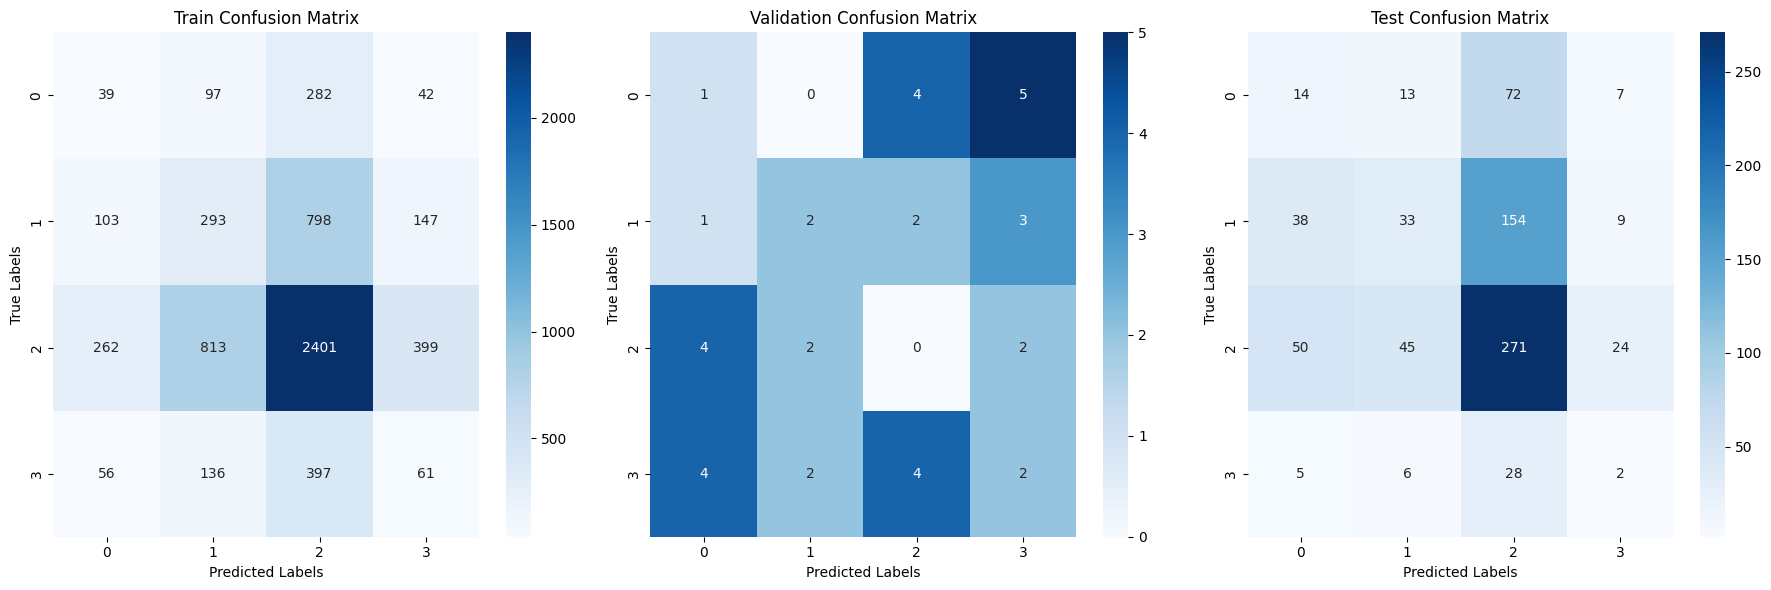

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Train Confusion Matrix
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Train Confusion Matrix')
axes[0].set_xlabel('Predicted Labels')
axes[0].set_ylabel('True Labels')

# Validation Confusion Matrix
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Validation Confusion Matrix')
axes[1].set_xlabel('Predicted Labels')
axes[1].set_ylabel('True Labels')

# Test Confusion Matrix
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[2])
axes[2].set_title('Test Confusion Matrix')
axes[2].set_xlabel('Predicted Labels')
axes[2].set_ylabel('True Labels')

# Adjust layout
plt.tight_layout()
plt.show()

# Even more finetuning

In [ ]:
# Load VGG16 with pre-trained ImageNet weights, excluding the top (fully connected) layers
base_model = VGG16(weights='imagenet',
                   include_top=False,
                   input_tensor=Input(shape=(224, 224, 3)))

# Freeze the first few layers
for layer in base_model.layers[:13]:  # Freeze first 13 layers, adjust as needed
    layer.trainable = False

# Unfreeze the remaining layers
for layer in base_model.layers[13:]:
    layer.trainable = True

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# Build the model
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',  # or 'categorical_crossentropy' if labels are one-hot encoded
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10,
)

Epoch 1/10
198/198 [==============================] - 220s 1s/step - loss: 0.4164 - accuracy: 0.9086 - val_loss: 0.1498 - val_accuracy: 0.9211
Epoch 2/10
198/198 [==============================] - 218s 1s/step - loss: 0.0894 - accuracy: 0.9720 - val_loss: 0.2718 - val_accuracy: 0.8684
Epoch 3/10
198/198 [==============================] - 217s 1s/step - loss: 0.0632 - accuracy: 0.9812 - val_loss: 0.0951 - val_accuracy: 0.9737
Epoch 4/10
198/198 [==============================] - 217s 1s/step - loss: 0.0476 - accuracy: 0.9844 - val_loss: 0.2545 - val_accuracy: 0.8947
Epoch 5/10
198/198 [==============================] - 216s 1s/step - loss: 0.0317 - accuracy: 0.9905 - val_loss: 0.0071 - val_accuracy: 1.0000
Epoch 6/10
198/198 [==============================] - 214s 1s/step - loss: 0.0447 - accuracy: 0.9874 - val_loss: 0.0791 - val_accuracy: 0.9737
Epoch 7/10
198/198 [==============================] - 214s 1s/step - loss: 0.0142 - accuracy: 0.9959 - val_loss: 0.0058 - val_accuracy: 1.0000

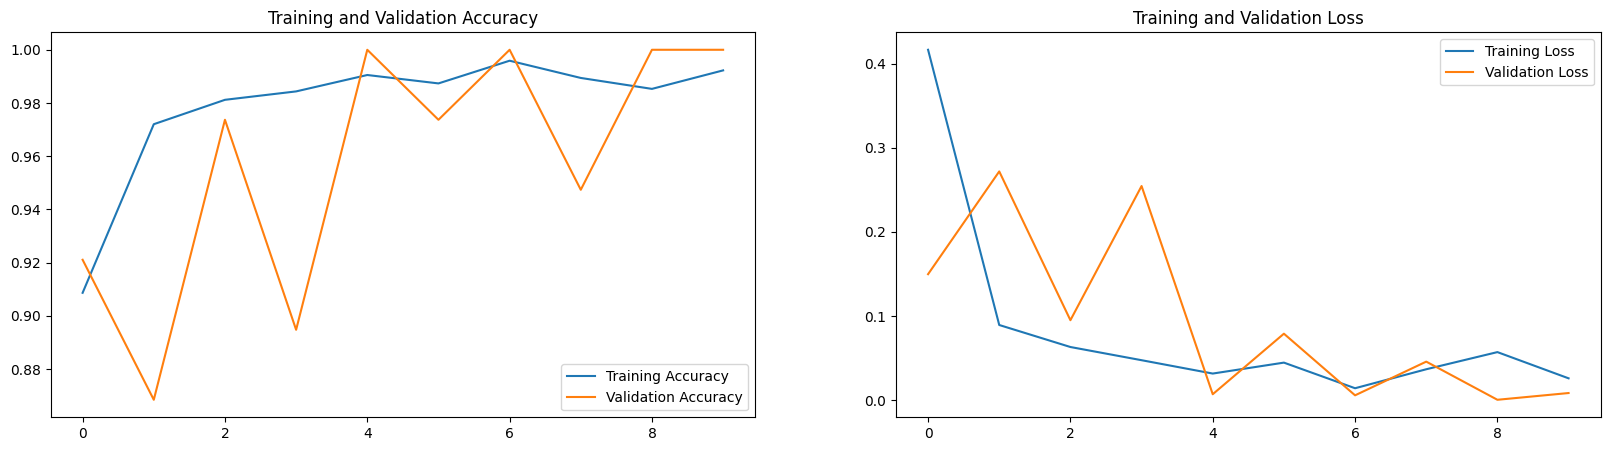

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

25/25 [==============================] - 14s 540ms/step - loss: 2.9442 - accuracy: 0.7367
Test Accuracy: 73.67%


In [ ]:
# Train set predictions
y_train_true = np.concatenate([y for x, y in train_dataset], axis=0)
y_train_pred = model.predict(train_dataset)
y_train_pred = np.argmax(y_train_pred, axis=1)

# Validation set predictions
y_val_true = np.concatenate([y for x, y in validation_dataset], axis=0)
y_val_pred = model.predict(validation_dataset)
y_val_pred = np.argmax(y_val_pred, axis=1)

# Test set predictions
y_test_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_test_pred = model.predict(test_dataset)
y_test_pred = np.argmax(y_test_pred, axis=1)

25/25 [==============================] - 14s 546ms/step


In [ ]:
from sklearn.metrics import confusion_matrix

# Confusion matrices
cm_train = confusion_matrix(y_train_true, y_train_pred)
cm_val = confusion_matrix(y_val_true, y_val_pred)
cm_test = confusion_matrix(y_test_true, y_test_pred)

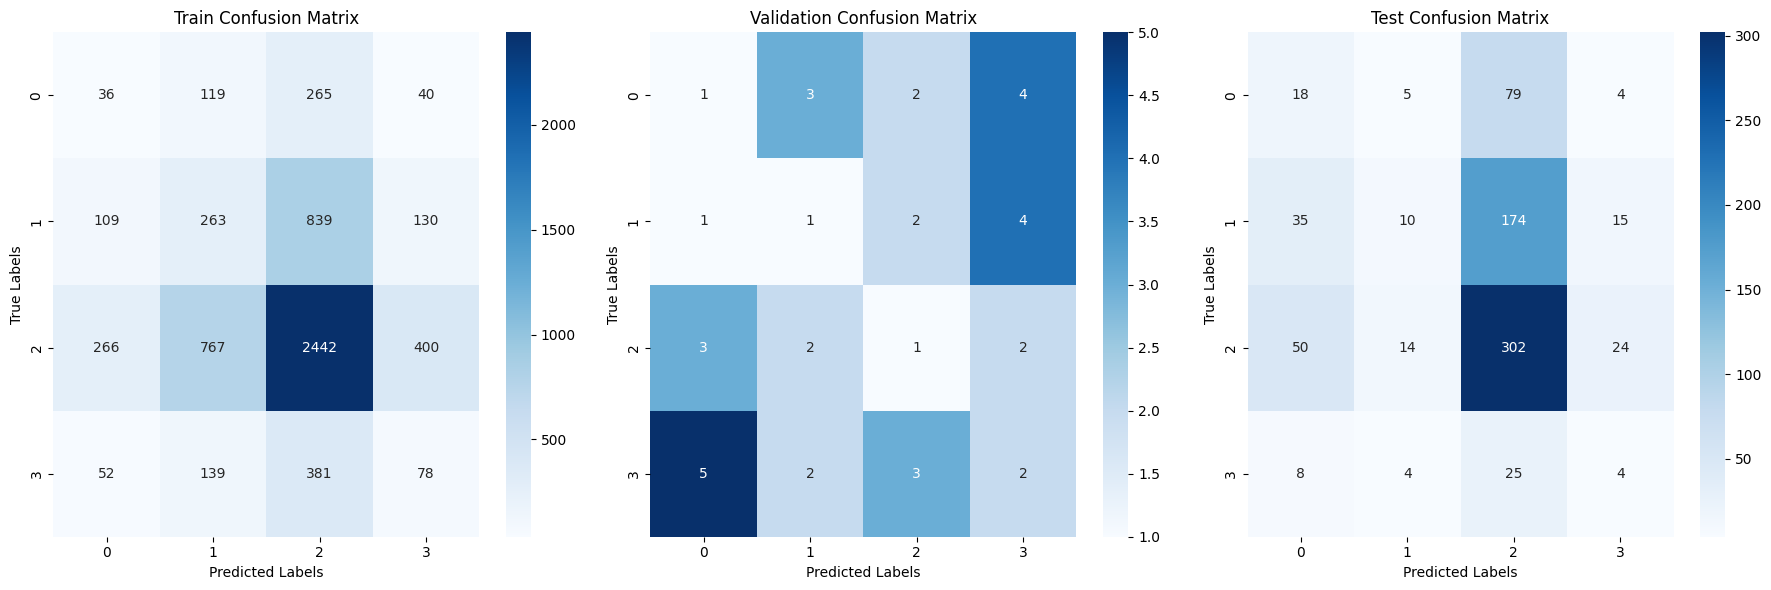

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Train Confusion Matrix
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Train Confusion Matrix')
axes[0].set_xlabel('Predicted Labels')
axes[0].set_ylabel('True Labels')

# Validation Confusion Matrix
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Validation Confusion Matrix')
axes[1].set_xlabel('Predicted Labels')
axes[1].set_ylabel('True Labels')

# Test Confusion Matrix
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[2])
axes[2].set_title('Test Confusion Matrix')
axes[2].set_xlabel('Predicted Labels')
axes[2].set_ylabel('True Labels')

# Adjust layout
plt.tight_layout()
plt.show()